#Import Dataset from Kaggle

In [ ]:
!pip install -q kaggle

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"benediktussatriya","key":"5571ef5062bae925b043b79195cc175c"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d grouplens/movielens-20m-dataset

 92% 180M/195M [00:02<00:00, 100MB/s]
100% 195M/195M [00:02<00:00, 87.3MB/s]


In [ ]:
!unzip /content/movielens-20m-dataset.zip

Archive:  /content/movielens-20m-dataset.zip
  inflating: genome_scores.csv       
  inflating: genome_tags.csv         
  inflating: link.csv                
  inflating: movie.csv               
  inflating: rating.csv              
  inflating: tag.csv                 


In [ ]:
!pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 KB 12.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp38-cp38-linux_x86_64.whl size=3366428 sha256=c89c3a73df5a45f6cff5b9aab6f5517f3b75cd2c9ef98733c9b636214ed368d5
  Stored in directory: /root/.cache/pip/wheels/af/db/86/2c18183a80ba05da35bf0fb7417aac5cddbd93bcb1b92fd3ea
Successfully built scikit-surprise


#Import Library

In [ ]:
import pandas as pd
import numpy as np
from surprise import Reader, Dataset, KNNWithMeans
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split

In [ ]:
df_ratings = pd.read_csv("/content/rating.csv")
df_titles = pd.read_csv("/content/movie.csv")

In [ ]:
df_movies =  pd.merge(df_ratings,df_titles, on="movieId", how="left",sort= False)
df_movies.head()

,userId,movieId,rating,timestamp,title,genres
0,1,2,3.5,2005-04-02 23:53:47,Jumanji (1995),Adventure|Children|Fantasy
1,1,29,3.5,2005-04-02 23:31:16,"City of Lost Children, The (Cité des enfants p...",Adventure|Drama|Fantasy|Mystery|Sci-Fi
2,1,32,3.5,2005-04-02 23:33:39,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller
3,1,47,3.5,2005-04-02 23:32:07,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,3.5,2005-04-02 23:29:40,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


In [ ]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000263 entries, 0 to 20000262
Data columns (total 6 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  object 
 4   title      object 
 5   genres     object 
dtypes: float64(1), int64(2), object(3)
memory usage: 1.0+ GB


In [ ]:
df_movies.shape

(20000263, 6)

That number of rows to much, ill gonna remove many rows and just use some.

In [ ]:
df_movies.drop(df_movies[(df_movies['userId'] >10)].index, inplace=True)
df_movies.shape

(960, 6)

Okay only 960 rows, much better

In [ ]:
df_movies.head()

,userId,movieId,rating,timestamp,title,genres
0,1,2,3.5,2005-04-02 23:53:47,Jumanji (1995),Adventure|Children|Fantasy
1,1,29,3.5,2005-04-02 23:31:16,"City of Lost Children, The (Cité des enfants p...",Adventure|Drama|Fantasy|Mystery|Sci-Fi
2,1,32,3.5,2005-04-02 23:33:39,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller
3,1,47,3.5,2005-04-02 23:32:07,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,3.5,2005-04-02 23:29:40,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


then ill gonna remove column timestamp, because i dont use it

In [ ]:
df_movies = df_movies.drop(['timestamp'], axis=1)

In [ ]:
df_movies.shape

(960, 5)

Okay the dataframe is ready to the next preprocessing

In [ ]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 960 entries, 0 to 959
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   userId   960 non-null    int64  
 1   movieId  960 non-null    int64  
 2   rating   960 non-null    float64
 3   title    960 non-null    object 
 4   genres   960 non-null    object 
dtypes: float64(1), int64(2), object(2)
memory usage: 77.3+ KB


In [ ]:
df_movies.isnull()

,userId,movieId,rating,title,genres
0,False,False,False,False,False
1,False,False,False,False,False
2,False,False,False,False,False
3,False,False,False,False,False
4,False,False,False,False,False
...,...,...,...,...,...
955,False,False,False,False,False
956,False,False,False,False,False
957,False,False,False,False,False
958,False,False,False,False,False


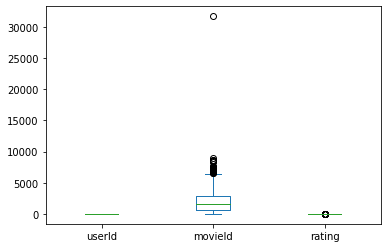

In [ ]:
df_movies[['userId','movieId','rating']].plot.box()

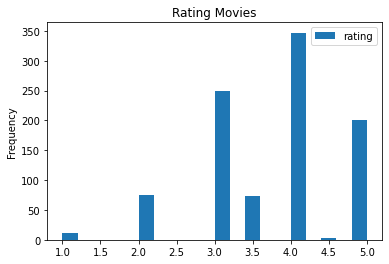

In [ ]:
df_movies[['rating']].plot.hist(bins = 20, title = 'Rating Movies')

In [ ]:
corr = df_movies[['userId','movieId','rating','genres', 'title']].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(4)

<ipython-input-34-cb404968c6d9>:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='coolwarm').set_precision(4)


,userId,movieId,rating
userId,1.0000,-0.1830,-0.2031
movieId,-0.1830,1.0000,-0.0942
rating,-0.2031,-0.0942,1.0000


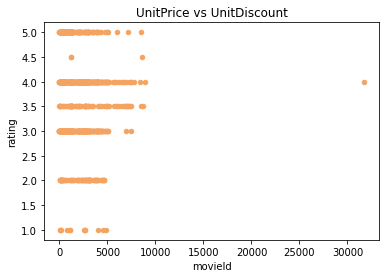

In [ ]:
df_movies.plot.scatter(x = 'movieId', y = 'rating',
                  color = 'sandybrown', title = 'UnitPrice vs UnitDiscount')

In [ ]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df_movies[['userId', 'movieId', 'rating']], reader)

In [ ]:
algo = KNNWithMeans(k=50, sim_options={'name': 'pearson', 'user_based': True})

In [ ]:
trainset = data.build_full_trainset()
algo.fit(trainset)

Computing the pearson similarity matrix...
Done computing similarity matrix.


In [ ]:

def recommend(user_id, n=10):
    user_items = df_movies[df_movies['userId'] == user_id]['movieId'].tolist()
    preds = algo.test(trainset.build_anti_testset())
    preds = [p for p in preds if p.uid != user_id and p.iid not in user_items]
    preds = sorted(preds, key=lambda x: (x.est, x.iid), reverse=True)
    recs = df_movies[df_movies['movieId'].isin([i.iid for i in preds[:n]])][['movieId','title']]
    recs.rename(columns={'title': 'item_title'}, inplace=True)
    return recs



#Result Recommender system, the input by user id

In [ ]:
user_id = 9
print(recommend(user_id))

     movieId                                         item_title
142     5952      Lord of the Rings: The Two Towers, The (2002)
158     7153  Lord of the Rings: The Return of the King, The...
170     8507                                      Freaks (1932)
171     8636                                Spider-Man 2 (2004)


ill make with random user id range 1 to 10

In [ ]:
random_uId = np.random.randint(1,10)
print('user id: {}'.format(random_uId))
print(recommend(random_uId))

user id: 4
     movieId                                         item_title
142     5952      Lord of the Rings: The Two Towers, The (2002)
158     7153  Lord of the Rings: The Return of the King, The...
170     8507                                      Freaks (1932)
171     8636                                Spider-Man 2 (2004)


the recommender system with random user id, will randomed every time user run the code

#Evaluate with cross validator

In [ ]:
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9885  0.9706  0.9553  0.9030  0.9384  0.9512  0.0292  
MAE (testset)     0.7771  0.7565  0.7380  0.7029  0.7394  0.7428  0.0245  
Fit time          0.01    0.00    0.00    0.00    0.00    0.00    0.00    
Test time         0.00    0.00    0.00    0.00    0.00    0.00    0.00    


{'test_rmse': array([0.98849704, 0.97056321, 0.95532942, 0.90297737, 0.93844921]),
 'test_mae': array([0.77710881, 0.756535  , 0.73803251, 0.70288162, 0.73938939]),
 'fit_time': (0.006752490997314453,
  0.0014078617095947266,
  0.002607107162475586,
  0.0007569789886474609,
  0.0007238388061523438),
 'test_time': (0.004007816314697266,
  0.0018038749694824219,
  0.0015711784362792969,
  0.0014934539794921875,
  0.0018889904022216797)}

#-------------------------

#Implement the model with flask api

In [ ]:
from google.colab.output import eval_js
print(eval_js("google.colab.kernel.proxyPort(5000)"))

https://l7u74dtri-496ff2e9c6d22116-5000-colab.googleusercontent.com/


In [ ]:
from flask import Flask, render_template_string, request
app = Flask(__name__)



@app.route("/")
def home():
    id = 2
    data_df = recommend(id)
    raw = data_df.to_dict('records') 
    data = {"user_id": id,"data" : raw} 
    return data

@app.route("/table")
def table():
        random_uId = np.random.randint(1,10)
        data_df = recommend(random_uId)
        data_raw = data_df.to_dict('records') 
        return render_template_string('''
        <style>
        table, th, td {
             border: 1px solid black;
        }
        table {
            width:80%;
            border-collapse: collapse;
        }
        td {
            text-align: center
        }
        th:first-child, td:first-child {
            text-align: left
        }
        th:last-child, td:last-child {
            text-align: right
        }
        </style>
        <h1>Movie Recommendation for you!</h1>
        <h2>User Id : {{id}}</h2>
        <table>
                <tr>
                    
                    <th> Movie Id </th> 
                    <th> Title Movie </th>
                    
                </tr>
    
        {% for row in table_data %}
    
                <tr>
                  
                    <td>{{ row['movieId'] }}</td> 
                    <td>{{ row['item_title'] }}</td>
                    
                </tr>
        {% endfor %}
        </table>
    ''', table_data=data_raw, id = random_uId)
if __name__ == "__main__":
    app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


INFO:werkzeug: * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
INFO:werkzeug:127.0.0.1 - - [18/Jan/2023 10:00:50] "GET /table HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [18/Jan/2023 10:00:51] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [18/Jan/2023 10:00:52] "GET /table HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [18/Jan/2023 10:00:52] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [18/Jan/2023 10:00:53] "GET /table HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [18/Jan/2023 10:00:54] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [18/Jan/2023 10:00:54] "GET /table HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [18/Jan/2023 10:00:54] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [18/Jan/2023 10:00:55] "GET /table HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [18/Jan/2023 10:00:56] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [18/Jan/2023 10:00:56] "GET /table HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - -